# Package Installation

In [1]:
!pip install --quiet transformers>=4.40.0
!pip install --quiet torch>=2.0.0
!pip install --quiet accelerate
!pip install --quiet plotly
!pip install --quiet numpy pandas matplotlib seaborn
!pip install --quiet tqdm
!pip install --quiet psutil

# Gemma 2 Uncertainty Neuron Analysis with Complete Weight Analysis and LayerNorm Effects

=== System Information ===
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU device: NVIDIA A100-SXM4-40GB
GPU memory: 39 GB
System RAM: 83 GB
Available RAM: 78 GB

Loading google/gemma-2-2b model (FP16 precision)...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loading model (FP16 precision, this may take a few minutes)...


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

✅ Model successfully loaded to device: cuda:0
Model data type: torch.float16
Model parameter count: 2,614,341,888
Model layers: 26
Hidden dimension: 2304
Vocabulary size: 256000
GPU memory usage: 4986 MB
GPU memory cached: 5114 MB

=== Extracting SwiGLU Weights from Last Layer ===
Analyzing layer 25 (last layer)
Gate projection shape: torch.Size([9216, 2304])
Up projection shape: torch.Size([9216, 2304])
Down projection shape: torch.Size([2304, 9216])
Unembedding matrix shape: torch.Size([256000, 2304])
✅ Weight extraction complete!

=== Computing Enhanced Metrics ===
LogitVar - mean: 0.000004, std: 0.000001
Weight norms - mean: 0.332084, std: 0.050034
Null space fraction - mean: 0.113121, std: 0.047487
LayerNorm effect - mean: 0.012592, std: 0.033589

=== Uncertainty Neuron Candidates ===
Low LogitVar threshold: 0.000003
High weight norm threshold: 0.373571
High null space fraction threshold: 0.142683
Found 29 candidates (low LogitVar + high norm)
Found 8 strong candidates (+ high Lay

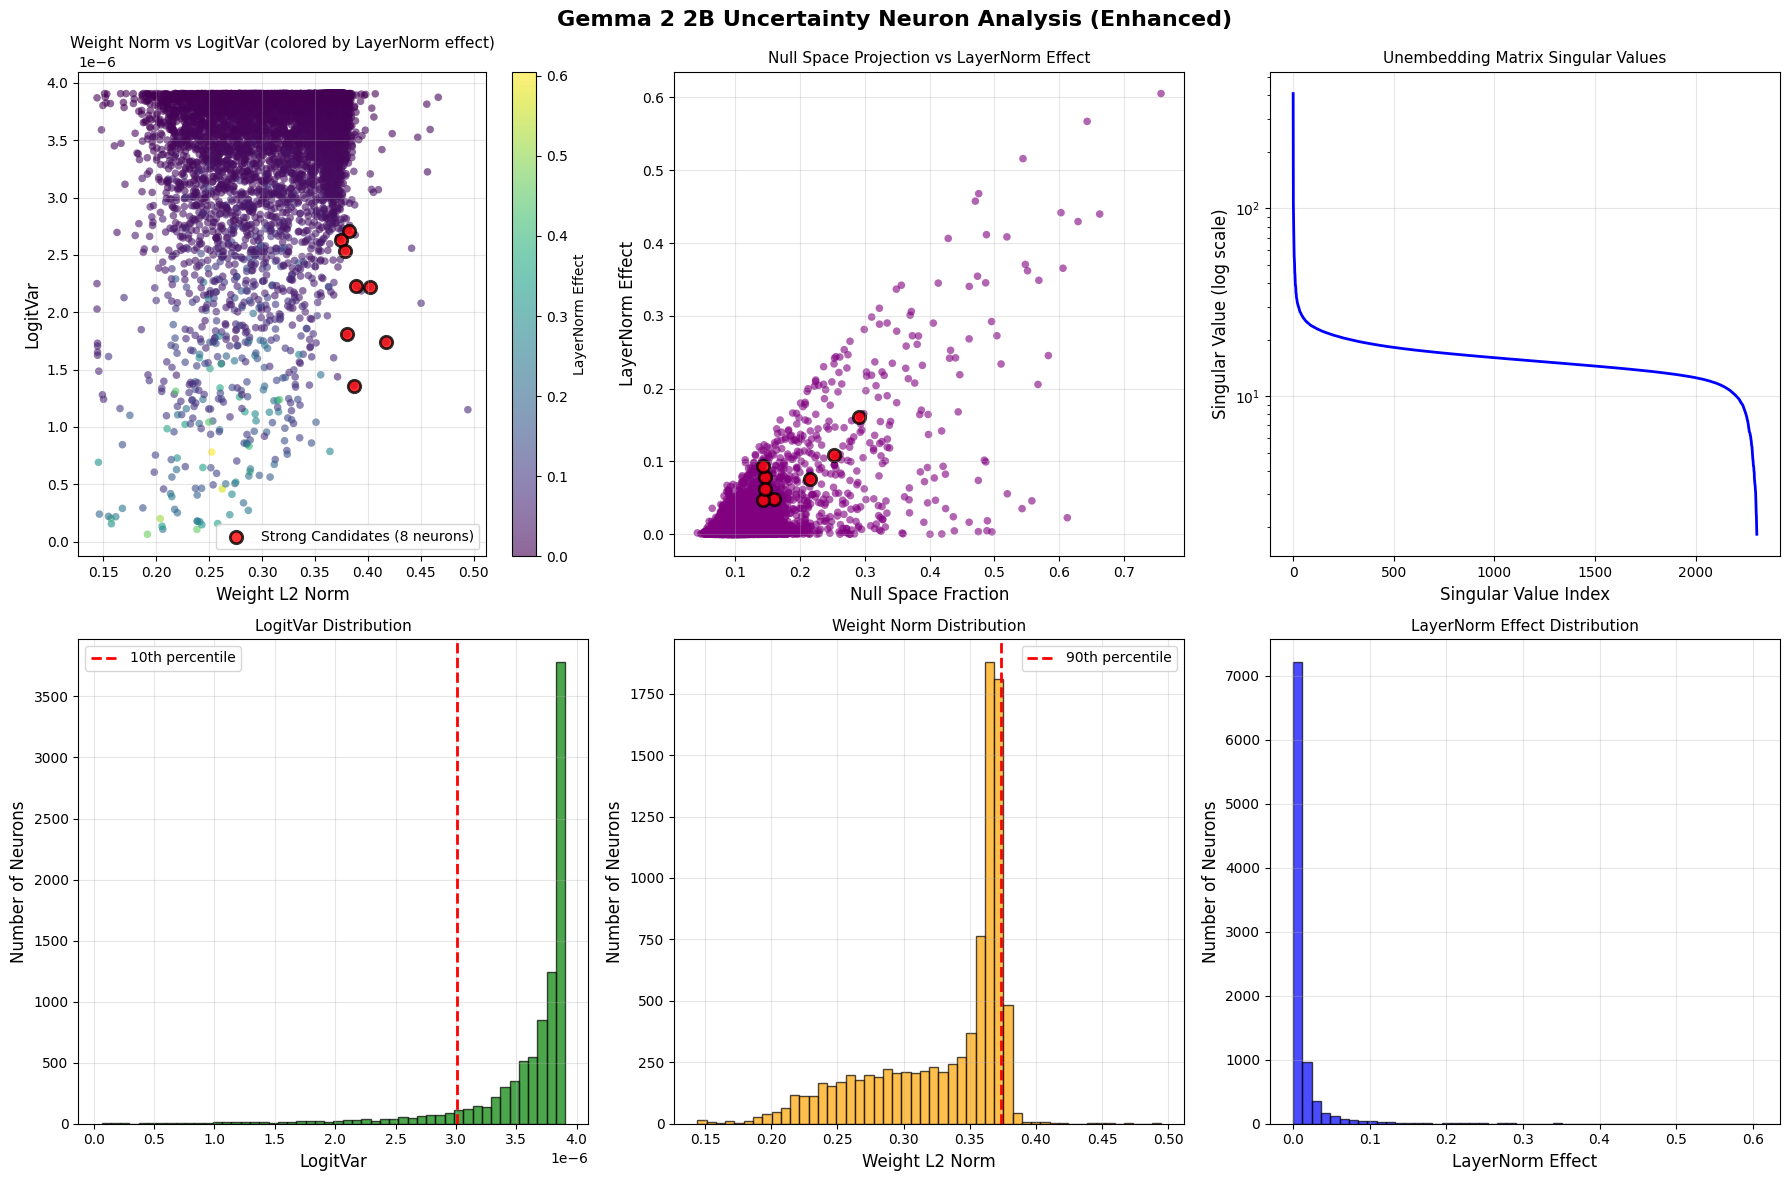


Running causal intervention experiment...
Testing neurons: [1939, 1974, 2109, 3461, 6481]

=== Running Causal Intervention Experiment ===


Testing: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s]


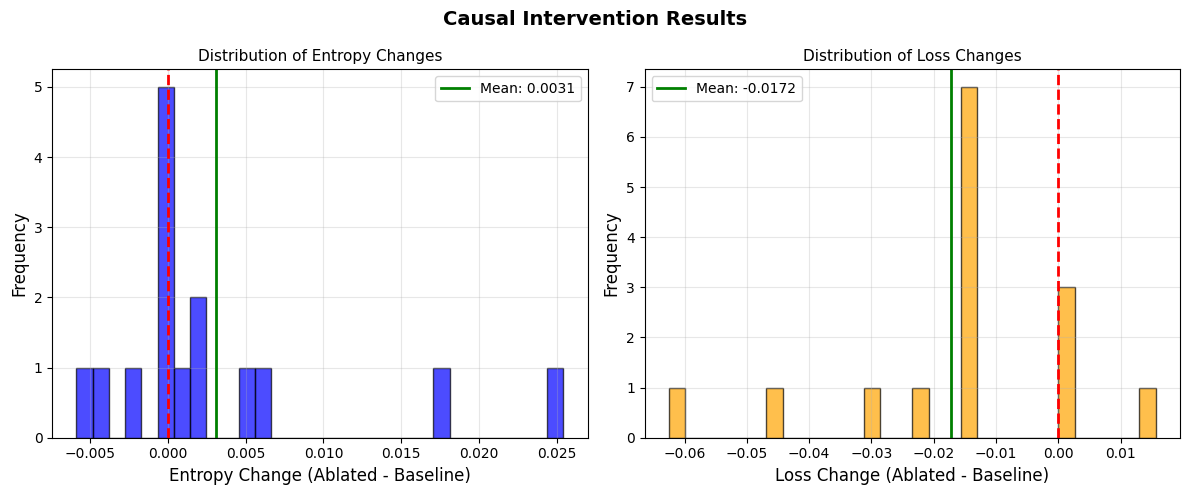


=== Intervention Summary ===
Mean entropy change: 0.0031
Mean loss change: -0.0172
❓ Weak evidence: Further investigation needed

🎉 Analysis complete!

Final GPU memory: 4995 MB


In [2]:
# Optimized Gemma 2 Uncertainty Neuron Analysis with Complete Weight Analysis and LayerNorm Effects

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import gc
import psutil

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# PART 1: ENVIRONMENT SETUP & MODEL LOADING
# ============================================================================

def check_system():
    """Check GPU and memory status"""
    print("=== System Information ===")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU device: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

    print(f"System RAM: {psutil.virtual_memory().total // 1024**3} GB")
    print(f"Available RAM: {psutil.virtual_memory().available // 1024**3} GB")
    torch.cuda.empty_cache()

def load_model(model_name="google/gemma-2-2b"):
    """Load Gemma 2 model in FP16 precision"""
    print(f"\nLoading {model_name} model (FP16 precision)...")

    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        print("Loading model (FP16 precision, this may take a few minutes)...")
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            torch_dtype=torch.float16,
            trust_remote_code=True,
            low_cpu_mem_usage=True,
        )

        print(f"✅ Model successfully loaded to device: {next(model.parameters()).device}")
        print(f"Model data type: {next(model.parameters()).dtype}")
        print(f"Model parameter count: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Model layers: {model.config.num_hidden_layers}")
        print(f"Hidden dimension: {model.config.hidden_size}")
        print(f"Vocabulary size: {model.config.vocab_size}")

        if torch.cuda.is_available():
            print(f"GPU memory usage: {torch.cuda.memory_allocated() // 1024**2} MB")
            print(f"GPU memory cached: {torch.cuda.memory_reserved() // 1024**2} MB")

        return model, tokenizer

    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        raise

# ============================================================================
# PART 2: ENHANCED WEIGHT EXTRACTION FOR SWIGLU
# ============================================================================

def extract_swiglu_weights(model):
    """
    Extract all SwiGLU weights from the last layer.
    For SwiGLU: hidden_states = down_proj(silu(gate_proj(x)) * up_proj(x))
    """
    print("\n=== Extracting SwiGLU Weights from Last Layer ===")

    last_layer_idx = model.config.num_hidden_layers - 1
    print(f"Analyzing layer {last_layer_idx} (last layer)")

    try:
        last_layer = model.model.layers[last_layer_idx]

        # Extract all three projection weights
        gate_proj = last_layer.mlp.gate_proj.weight.data  # (intermediate_size, hidden_size)
        up_proj = last_layer.mlp.up_proj.weight.data      # (intermediate_size, hidden_size)
        down_proj = last_layer.mlp.down_proj.weight.data  # (hidden_size, intermediate_size)

        # Get unembedding matrix
        unembed_matrix = model.lm_head.weight.data  # (vocab_size, hidden_size)

        print(f"Gate projection shape: {gate_proj.shape}")
        print(f"Up projection shape: {up_proj.shape}")
        print(f"Down projection shape: {down_proj.shape}")
        print(f"Unembedding matrix shape: {unembed_matrix.shape}")

        # For analysis, we focus on down_proj as it's the output weights
        # But we'll also compute combined effects considering gate and up projections
        W_out = down_proj.T  # Transpose to (intermediate_size, hidden_size)

        # Convert to CPU for analysis
        W_out_cpu = W_out.cpu()
        gate_proj_cpu = gate_proj.cpu()
        up_proj_cpu = up_proj.cpu()
        unembed_cpu = unembed_matrix.cpu()

        print("✅ Weight extraction complete!")

        return {
            'W_out': W_out_cpu,
            'gate_proj': gate_proj_cpu,
            'up_proj': up_proj_cpu,
            'unembed': unembed_cpu,
            'last_layer': last_layer
        }

    except Exception as e:
        print(f"❌ Weight extraction failed: {e}")
        raise

# ============================================================================
# PART 3: ENHANCED LOGITVAR WITH LAYERNORM EFFECTS
# ============================================================================

def compute_effective_null_space(unembed_matrix, k_ratio=0.01):
    """
    Compute the effective null space of the unembedding matrix
    k_ratio: fraction of dimensions to consider as null space
    """
    U, S, Vt = torch.linalg.svd(unembed_matrix.float(), full_matrices=False)
    k = int(k_ratio * len(S))

    # Identify sharp drop in singular values
    if len(S) > 1:
        ratios = S[:-1] / S[1:]
        sharp_drops = torch.where(ratios > 10)[0]
        if len(sharp_drops) > 0:
            k = max(k, len(S) - sharp_drops[-1].item() - 1)

    null_space_vectors = Vt[-k:, :].T  # (hidden_size, k)

    return null_space_vectors, S

def calculate_enhanced_metrics(weights_dict):
    """
    Calculate both direct LogitVar and LayerNorm-mediated effects
    """
    W_out = weights_dict['W_out']
    unembed = weights_dict['unembed']

    print("\n=== Computing Enhanced Metrics ===")

    # 1. Standard LogitVar (Direct Effect)
    W_out_f32 = W_out.float()
    unembed_f32 = unembed.float()

    projections = W_out_f32 @ unembed_f32.T
    norms = torch.norm(projections, dim=1, keepdim=True)
    norms = torch.clamp(norms, min=1e-10)
    normalized_projections = projections / norms

    mask = torch.isfinite(normalized_projections).all(dim=1)
    logit_vars = torch.full((normalized_projections.shape[0],), float('nan'))
    logit_vars[mask] = torch.var(normalized_projections[mask], dim=1)

    # 2. Weight norms
    weight_norms = torch.norm(W_out_f32, dim=1)

    # 3. Projection norms
    projection_norms = norms.squeeze()

    # 4. Null space projection (LayerNorm effect indicator)
    null_space_vectors, singular_values = compute_effective_null_space(unembed)
    null_space_projection = W_out_f32 @ null_space_vectors
    null_space_norms = torch.norm(null_space_projection, dim=1)
    total_norms = torch.norm(W_out_f32, dim=1)
    null_space_fraction = null_space_norms / (total_norms + 1e-10)

    # 5. Estimate LayerNorm-mediated effect
    # Neurons with high null space fraction affect residual stream norm without affecting logits
    layernorm_effect = null_space_fraction * (1 - logit_vars / logit_vars.max())

    print(f"LogitVar - mean: {logit_vars.mean():.6f}, std: {logit_vars.std():.6f}")
    print(f"Weight norms - mean: {weight_norms.mean():.6f}, std: {weight_norms.std():.6f}")
    print(f"Null space fraction - mean: {null_space_fraction.mean():.6f}, std: {null_space_fraction.std():.6f}")
    print(f"LayerNorm effect - mean: {layernorm_effect.mean():.6f}, std: {layernorm_effect.std():.6f}")

    return {
        'logit_vars': logit_vars,
        'weight_norms': weight_norms,
        'projection_norms': projection_norms,
        'null_space_fraction': null_space_fraction,
        'layernorm_effect': layernorm_effect,
        'singular_values': singular_values
    }

# ============================================================================
# PART 4: UNCERTAINTY NEURON IDENTIFICATION
# ============================================================================

def identify_uncertainty_neurons(metrics, percentile_threshold=10):
    """
    Identify uncertainty neurons using multiple criteria:
    1. Low LogitVar (bottom percentile)
    2. High weight norm (top percentile)
    3. High null space fraction (LayerNorm effect)
    """
    logit_vars = metrics['logit_vars']
    weight_norms = metrics['weight_norms']
    null_space_fraction = metrics['null_space_fraction']
    layernorm_effect = metrics['layernorm_effect']

    # Thresholds
    logit_var_threshold = torch.nanquantile(logit_vars, percentile_threshold/100)
    weight_norm_threshold = torch.nanquantile(weight_norms, 1 - percentile_threshold/100)
    null_space_threshold = torch.nanquantile(null_space_fraction, 1 - percentile_threshold/100)

    # Criteria for uncertainty neurons
    low_logit_var = logit_vars < logit_var_threshold
    high_weight_norm = weight_norms > weight_norm_threshold
    high_null_space = null_space_fraction > null_space_threshold

    # Combined criteria
    uncertainty_candidates = low_logit_var & high_weight_norm
    strong_candidates = uncertainty_candidates & high_null_space

    print(f"\n=== Uncertainty Neuron Candidates ===")
    print(f"Low LogitVar threshold: {logit_var_threshold:.6f}")
    print(f"High weight norm threshold: {weight_norm_threshold:.6f}")
    print(f"High null space fraction threshold: {null_space_threshold:.6f}")
    print(f"Found {uncertainty_candidates.sum().item()} candidates (low LogitVar + high norm)")
    print(f"Found {strong_candidates.sum().item()} strong candidates (+ high LayerNorm effect)")

    if strong_candidates.sum() > 0:
        indices = torch.where(strong_candidates)[0]
        print(f"\nTop 10 strong candidate neurons:")
        for i, idx in enumerate(indices[:10]):
            print(f"  Neuron {idx.item():4d}: LogitVar={logit_vars[idx]:.4e}, "
                  f"Weight norm={weight_norms[idx]:.4f}, "
                  f"Null space={null_space_fraction[idx]:.4f}, "
                  f"LayerNorm effect={layernorm_effect[idx]:.4f}")

    return uncertainty_candidates, strong_candidates

# ============================================================================
# PART 5: CAUSAL INTERVENTION EXPERIMENTS
# ============================================================================

def create_ablation_hook(neuron_indices, intervention_type='mean'):
    """Create hook function for neuron ablation"""
    def hook_fn(module, input, output):
        if intervention_type == 'zero':
            for idx in neuron_indices:
                if idx < output.shape[-1]:
                    output[:, :, idx] = 0
        elif intervention_type == 'mean':
            # Use batch mean for more stable ablation
            batch_mean = output.mean(dim=[0, 1], keepdim=True)
            for idx in neuron_indices:
                if idx < output.shape[-1]:
                    output[:, :, idx] = batch_mean[:, :, idx]
        return output
    return hook_fn

def calculate_entropy(logits):
    """Calculate prediction entropy"""
    log_probs = torch.log_softmax(logits, dim=-1)
    probs = torch.softmax(logits, dim=-1)
    entropy = -torch.sum(probs * log_probs, dim=-1)
    return entropy

def run_causal_intervention(model, tokenizer, test_sentences, neuron_indices, weights_dict):
    """
    Run causal intervention experiment with LayerNorm consideration
    """
    results = {
        'sentences': [],
        'baseline_entropy': [],
        'ablated_entropy': [],
        'entropy_change': [],
        'baseline_loss': [],
        'ablated_loss': [],
        'loss_change': []
    }

    target_layer = weights_dict['last_layer'].mlp

    print("\n=== Running Causal Intervention Experiment ===")
    for sentence in tqdm(test_sentences, desc="Testing"):
        inputs = tokenizer(sentence, return_tensors="pt").to(model.device)

        # Baseline prediction
        with torch.no_grad():
            baseline_outputs = model(**inputs)
            baseline_logits = baseline_outputs.logits[0, -1]
            baseline_entropy = calculate_entropy(baseline_logits).item()
            baseline_loss = torch.nn.functional.cross_entropy(
                baseline_logits.unsqueeze(0),
                torch.tensor([tokenizer.eos_token_id]).to(model.device)
            ).item()

        # Ablated prediction
        hook = target_layer.register_forward_hook(
            create_ablation_hook(neuron_indices, 'mean')
        )

        with torch.no_grad():
            ablated_outputs = model(**inputs)
            ablated_logits = ablated_outputs.logits[0, -1]
            ablated_entropy = calculate_entropy(ablated_logits).item()
            ablated_loss = torch.nn.functional.cross_entropy(
                ablated_logits.unsqueeze(0),
                torch.tensor([tokenizer.eos_token_id]).to(model.device)
            ).item()

        hook.remove()

        # Store results
        results['sentences'].append(sentence)
        results['baseline_entropy'].append(baseline_entropy)
        results['ablated_entropy'].append(ablated_entropy)
        results['entropy_change'].append(ablated_entropy - baseline_entropy)
        results['baseline_loss'].append(baseline_loss)
        results['ablated_loss'].append(ablated_loss)
        results['loss_change'].append(ablated_loss - baseline_loss)

    return results

# ============================================================================
# PART 6: VISUALIZATION
# ============================================================================

def visualize_results(metrics, uncertainty_candidates, strong_candidates):
    """Create comprehensive visualization of results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Gemma 2 2B Uncertainty Neuron Analysis (Enhanced)', fontsize=16, fontweight='bold')

    # 1. Weight norm vs LogitVar with LayerNorm effect
    ax1 = axes[0, 0]
    scatter = ax1.scatter(metrics['weight_norms'], metrics['logit_vars'],
                         c=metrics['layernorm_effect'], cmap='viridis',
                         alpha=0.6, s=30, edgecolors='none')
    plt.colorbar(scatter, ax=ax1, label='LayerNorm Effect')

    # Highlight candidates
    if strong_candidates.sum() > 0:
        candidate_x = metrics['weight_norms'][strong_candidates]
        candidate_y = metrics['logit_vars'][strong_candidates]
        ax1.scatter(candidate_x, candidate_y, c='red', s=80, marker='o',
                   edgecolors='black', linewidths=2, alpha=0.8,
                   label=f'Strong Candidates ({strong_candidates.sum()} neurons)')

    ax1.set_xlabel('Weight L2 Norm', fontsize=12)
    ax1.set_ylabel('LogitVar', fontsize=12)
    ax1.set_title('Weight Norm vs LogitVar (colored by LayerNorm effect)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Null space fraction vs LayerNorm effect
    ax2 = axes[0, 1]
    ax2.scatter(metrics['null_space_fraction'], metrics['layernorm_effect'],
               alpha=0.6, s=30, c='purple', edgecolors='none')
    if strong_candidates.sum() > 0:
        ax2.scatter(metrics['null_space_fraction'][strong_candidates],
                   metrics['layernorm_effect'][strong_candidates],
                   c='red', s=80, marker='o', edgecolors='black', linewidths=2, alpha=0.8)
    ax2.set_xlabel('Null Space Fraction', fontsize=12)
    ax2.set_ylabel('LayerNorm Effect', fontsize=12)
    ax2.set_title('Null Space Projection vs LayerNorm Effect', fontsize=11)
    ax2.grid(True, alpha=0.3)

    # 3. Singular values of unembedding
    ax3 = axes[0, 2]
    ax3.semilogy(metrics['singular_values'].numpy(), 'b-', linewidth=2)
    ax3.set_xlabel('Singular Value Index', fontsize=12)
    ax3.set_ylabel('Singular Value (log scale)', fontsize=12)
    ax3.set_title('Unembedding Matrix Singular Values', fontsize=11)
    ax3.grid(True, alpha=0.3)

    # 4. LogitVar distribution
    ax4 = axes[1, 0]
    valid_logit_vars = metrics['logit_vars'][~torch.isnan(metrics['logit_vars'])]
    ax4.hist(valid_logit_vars.numpy(), bins=50, alpha=0.7, color='green', edgecolor='black')
    ax4.axvline(torch.nanquantile(metrics['logit_vars'], 0.1),
               color='red', linestyle='--', linewidth=2, label='10th percentile')
    ax4.set_xlabel('LogitVar', fontsize=12)
    ax4.set_ylabel('Number of Neurons', fontsize=12)
    ax4.set_title('LogitVar Distribution', fontsize=11)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Weight norm distribution
    ax5 = axes[1, 1]
    ax5.hist(metrics['weight_norms'].numpy(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax5.axvline(torch.nanquantile(metrics['weight_norms'], 0.9),
               color='red', linestyle='--', linewidth=2, label='90th percentile')
    ax5.set_xlabel('Weight L2 Norm', fontsize=12)
    ax5.set_ylabel('Number of Neurons', fontsize=12)
    ax5.set_title('Weight Norm Distribution', fontsize=11)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. LayerNorm effect distribution
    ax6 = axes[1, 2]
    ax6.hist(metrics['layernorm_effect'].numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax6.set_xlabel('LayerNorm Effect', fontsize=12)
    ax6.set_ylabel('Number of Neurons', fontsize=12)
    ax6.set_title('LayerNorm Effect Distribution', fontsize=11)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_intervention_results(results):
    """Visualize causal intervention results"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Causal Intervention Results', fontsize=14, fontweight='bold')

    # Entropy changes
    ax1 = axes[0]
    ax1.hist(results['entropy_change'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Entropy Change (Ablated - Baseline)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Entropy Changes', fontsize=11)
    mean_change = np.mean(results['entropy_change'])
    ax1.axvline(mean_change, color='green', linestyle='-', linewidth=2,
               label=f'Mean: {mean_change:.4f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss changes
    ax2 = axes[1]
    ax2.hist(results['loss_change'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Loss Change (Ablated - Baseline)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Loss Changes', fontsize=11)
    mean_loss_change = np.mean(results['loss_change'])
    ax2.axvline(mean_loss_change, color='green', linestyle='-', linewidth=2,
               label=f'Mean: {mean_loss_change:.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================================================
# PART 7: TEST DATA
# ============================================================================

def get_test_sentences():
    """Get diverse test sentences for causal intervention"""
    return [
        # High uncertainty (epistemic)
        "The population of Nauru in 2024 is",
        "The CEO of startup company Zephyr Labs is",
        "The atomic weight of Flerovium is",
        "The Hausdorff dimension of the Sierpinski triangle is",

        # High uncertainty (aleatoric)
        "The best programming language is",
        "The most important thing in life is",
        "She told him that",
        "The reason for this is",

        # Ambiguous
        "The bank is",
        "The bat flew",
        "Flying planes can be dangerous",

        # Low uncertainty
        "The capital of USA is",
        "Two plus two equals",
        "The sun rises in the",
        "The color of grass is",
    ]

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    # 1. System check
    check_system()

    # 2. Load model
    model, tokenizer = load_model("google/gemma-2-2b")

    # 3. Extract weights
    weights_dict = extract_swiglu_weights(model)

    # 4. Calculate enhanced metrics
    metrics = calculate_enhanced_metrics(weights_dict)

    # 5. Identify uncertainty neurons
    uncertainty_candidates, strong_candidates = identify_uncertainty_neurons(metrics)

    # 6. Visualize results
    visualize_results(metrics, uncertainty_candidates, strong_candidates)

    # 7. Run causal intervention (optional, computationally intensive)
    if strong_candidates.sum() > 0:
        print("\n" + "="*50)
        print("Running causal intervention experiment...")
        print("="*50)

        # Select top 5 strong candidates for testing
        test_neuron_indices = torch.where(strong_candidates)[0][:5].tolist()
        print(f"Testing neurons: {test_neuron_indices}")

        # Get test sentences
        test_sentences = get_test_sentences()

        # Run intervention
        intervention_results = run_causal_intervention(
            model, tokenizer, test_sentences, test_neuron_indices, weights_dict
        )

        # Visualize intervention results
        visualize_intervention_results(intervention_results)

        # Print summary
        print("\n=== Intervention Summary ===")
        print(f"Mean entropy change: {np.mean(intervention_results['entropy_change']):.4f}")
        print(f"Mean loss change: {np.mean(intervention_results['loss_change']):.4f}")

        if np.mean(intervention_results['entropy_change']) < -0.1:
            print("✅ Strong evidence: These neurons regulate uncertainty!")
        elif np.mean(intervention_results['entropy_change']) < -0.05:
            print("✅ Moderate evidence: These neurons likely regulate uncertainty")
        else:
            print("❓ Weak evidence: Further investigation needed")

    print("\n🎉 Analysis complete!")

    # Clean up
    if torch.cuda.is_available():
        print(f"\nFinal GPU memory: {torch.cuda.memory_allocated() // 1024**2} MB")
        torch.cuda.empty_cache()

    return model, tokenizer, weights_dict, metrics

if __name__ == "__main__":
    model, tokenizer, weights_dict, metrics = main()